In [1]:
import numpy as np # library for efficient and fast array computations
import matplotlib.pyplot as plt # library for plotting 
import math                       # library for mathematical equations
import pandas as pd               # library for loading data from file (in our case csv file)

In [2]:
def compute_cost_logistic_regression(X, y, w, b, lambda_l = 1):
    '''
    Description: computes the cost for regularized logistic regression
    ( the term with the numerator lambda helps to minimize the size of the parameters 
    (w1, w2,...),
    but I use the version where b is not regularized )
    Preconditions: X - m x n matrix which contains our data 
                    y - m size array - target values
                    w - n size array - model parameters
                    b - real number - free term parameter
                    lambda_l - real number - quantifier for regularization
    Postconditons: total_cost - real number - the cost of our calculations, which will help
    later to build a better model
    '''
    m = X.shape[0] # number of input data examples
    n = X.shape[1] # number of features of each example

    cost = 0.0
    for i in range(m):
        z = np.dot(X[i],w)+b
        z = np.clip( z, -500, 500 )             # bring the data in a more compact range
        f_wb = 1.0/(1.0+ np.exp(-z))            # the formula of logistic regression model
        cost += -y[i] * np.log(f_wb) - (1-y[i]) * np.log(1 - f_wb)
    cost /= m
     # until here, we just applied the formula of the cost without regularization

    # the regularization part
    reg_cost = 0
    for j in range(n):
        reg_cost += w[j]**2
    reg_cost *= lambda_l/(2*m)

    # adding the 2 costs
    total_cost = cost + reg_cost
    return total_cost

In [3]:
def compute_gradient(X, y, w, b, lambda_l):
    '''
    Description: computes the partial derivative of the w vector and b scalar used in the gradient descent algorithm 
    Preconditions: X - m x n matrix which contains our data 
                    y - m size array - target values
                    w - n size array - model parameters
                    b - real number - free term parameter
                    lambda_l - real number - quantifier for regularization
    Postconditons: dj_dw - n array (size of w) and dj_db - scalar
    '''
    m = X.shape[0]
    n = X.shape[1]

    dj_dw= np.zeros((n,))    # null vector of n size
    dj_db = 0.0

    for i in range(m):
        z = np.dot(X[i],w)+b
        z = np.clip( z, -500, 500 )             # bring the data in a more compact range
        f_wb = 1.0/(1.0+ np.exp(-z))
        dj_db += f_wb - y[i] # forming the derivative of b 

       # forming the gradient of w - unregularized part for now
        for j in range(n):
            dj_dw[j] += (f_wb - y[i])*X[i,j]

    dj_dw /= m
    dj_db /= m

    #now add the regularization part for the w feature vector
    for j in range(n):
        dj_dw[j] += (lambda_l/m) * w[j]

    return dj_db, dj_dw

In [4]:
# apply z-score normalization to adjust the data based on its distribution, so our model will perform faster and better 
# gradient descent will converge faster
def zscore_normalize_features(X): 
    # description: computes  X, zcore normalized by column
    # pre: X - mxn array
    # post: X_norm : normalized data 

    # find the mean of each feature, by columns
    mu = np.mean(X, axis = 0) # nD array
    # find the standard deviation of each column
    sigma = np.std(X, axis=0) # nD array
    # apply the formula of the z-score normalization
    X_norm = (X - mu) / sigma      

    return X_norm

In [5]:
# this is where FOOD INPUT DATA is taken as input

'''
We have 25 examples of healthy and unhealthy foods.
As target values, we have the classes healthy/unhealthy, marked with 1(healthy)/0(unhealthy)       - OUTPUT
Each food has 5 features (measured in 100g or ml):  
 - Total Fat (g)
 - Saturated Fat (g)
 - Carbohydrates (g)                                                            - INPUT
 - Total Sugars (g) 
 - Protein (g)
 '''
food_data = pd.read_csv('food_data.csv') # load data from file
X = np.empty((0, 5), dtype=float)                     # empty array prepared for adding 5 features on each row
y = np.array([], dtype=int)              # we only have 0 and 1 , which are integers
for i in range(25):  
    input_i = np.array(food_data.iloc[i][1:6], dtype=float)
    target_i = food_data.iloc[i,6]                           # capture input & output values
    input_i = input_i.reshape(1, 5)  # reshape row_i to be a 2D array with 1 row 5 col (eg. [[1,2,3,4,5]] )
    X = np.append(X, input_i, axis=0)  # append along axis 0 (rows)
    y = np.append(y, target_i)
    
X_norm = zscore_normalize_features(X) # making all the input data matter the same for the model, by decreasing bias




In [7]:
def gradient_descent(X, y, w, b, compute_cost_logistic_regression, compute_gradient, alpha, iterations):
    '''
    Descriptions: performs batch gradient descent to learn w vector and b parameter, using learning rate alpha and number of iterations
    Preconditions: X - m x n matrix which contains our data 
                    y - m size array - target values
                    w - n size array - model parameters
                    b - real number - free term parameter
                    compute_cost_linear_regression, compute_gradient : functions to compute cost & gradient
                    alpha : learning rate
                    iterations: number of iterations
    Postconditons: w , b - updated values of parameters of the model & hist - array to store cost and w at every iteration
    '''
    hist = []
    for i in range(iterations):
        # calculate gradient for our parameters
        dj_db, dj_dw = compute_gradient(X, y, w, b,0.7)

        # update parameters using the learning rate
        w -= alpha* dj_dw
        b -= alpha* dj_db

        # save cost at every iteration if we do not have too many iterations (avoid resource exhaustion)
        if i<100000:
            hist.append(compute_cost_logistic_regression(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(iterations/ 10) == 0:
            print(f"Iteration {i:4d}: Cost {hist[-1]:8.2f}   ")

    return w, b, hist

In [8]:
w_in= np.zeros((X_norm.shape[1],)) # initialize the parameters with default values null vector and 0
b_in= 0

# choose number of iterations and learning rate alpha
iterations=1000  # these values may variate, but we sould try different values to make the model as accurate as possible
alpha=0.01

# predict the parameters wth gradient descent
#here we save all the values that we need later of aproximate values with new inputs
w,b,cost_history=gradient_descent(X_norm, y, w_in, b_in, compute_cost_logistic_regression, compute_gradient, alpha, iterations) 


print("w,b found by gradient descent:", w, b)


Iteration    0: Cost     0.69   
Iteration  100: Cost     0.56   
Iteration  200: Cost     0.51   
Iteration  300: Cost     0.48   
Iteration  400: Cost     0.46   
Iteration  500: Cost     0.45   
Iteration  600: Cost     0.45   
Iteration  700: Cost     0.44   
Iteration  800: Cost     0.44   
Iteration  900: Cost     0.43   
w,b found by gradient descent: [-0.59589935 -0.23153815 -0.55177941 -0.47203672  0.72118153] 0.5272577660562551


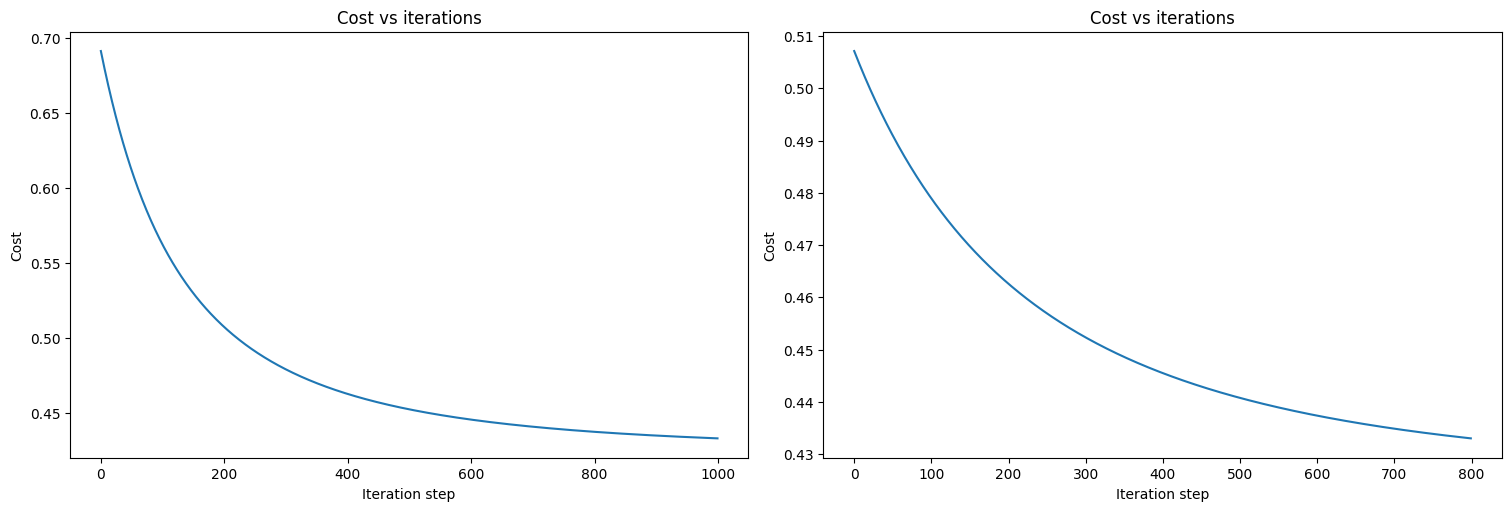

In [10]:

# plot the cost resulted, which is in our cost hist array

fig, (ax1, ax2) = plt.subplots(1,2, constrained_layout=True, figsize=(15,5)) # create 2 pictures in the same row to show how fast does the cost decrease
ax1.plot(cost_history)
ax1.set_title("Cost vs iterations")
ax1.set_xlabel("Iteration step")
ax1.set_ylabel("Cost")

ax2.plot(np.arange(len(cost_history[200:])), cost_history[200:])
ax2.set_title("Cost vs iterations")
ax2.set_xlabel("Iteration step")
ax2.set_ylabel("Cost")

plt.show()

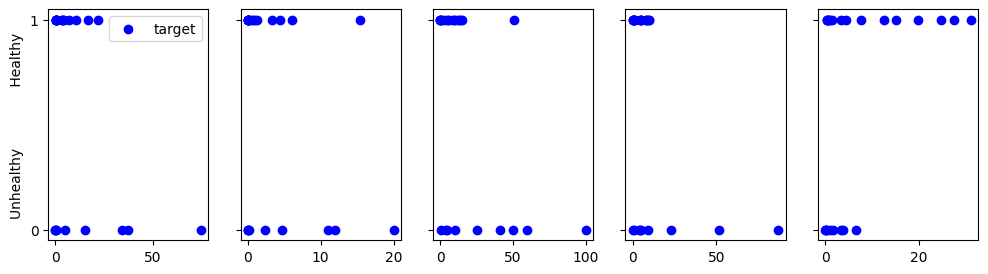

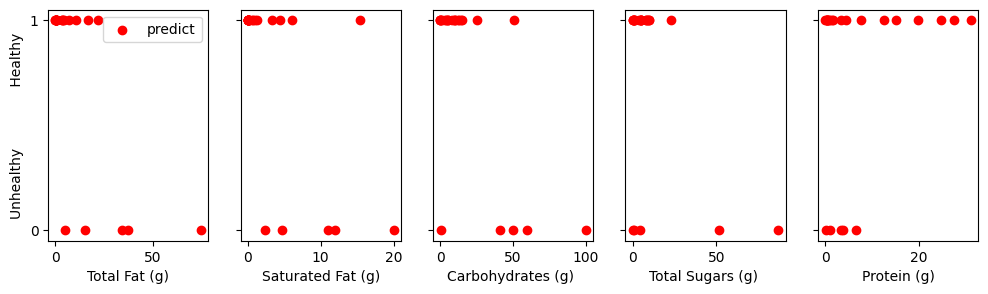

In [11]:
# prepare the predicted output for plotting
m = X_norm.shape[0]
yp = np.zeros(m)

# predict the output using the sigmoid function using w and b found before
for i in range(m):
  z = np.dot(X_norm[i],w)+b
  z = np.clip( z, -500, 500 )             # bring the data in a more compact range
  yp[i] = 1.0/(1.0+ np.exp(-z))

# transform the predicted output into boolean array to help us plot according to the value of every element
# if it is >= 0.5, we would consider that we are in a true (1 or healthy) situation, else it is the 0 or false case
yp = (yp >= 0.5)

X_features = ["Total Fat (g)", "Saturated Fat (g)", "Carbohydrates (g) ", "Total Sugars (g) ", "Protein (g)"]


#structure the plot into 2 rows with n (nr features) columns
fig1, ax1 = plt.subplots(1,X.shape[1], figsize=(12,3), sharey=True)
fig2, ax2 = plt.subplots(1,X.shape[1], figsize=(12,3), sharey=True)


for i in range(len(ax1)):
  ax1[i].scatter( X[:,i], y, color="blue", label='target')
  ax2[i].scatter( X[:,i], yp, color='red', label='predict')  # plot every feature target and predction to compare them
  ax2[i].set_xlabel(X_features[i])

y_ticks = [0, 1]
ax1[0].set_yticks(y_ticks)  # set y-ticks for the first row   - only 0 and 1 ( CLASSIFICATION CLASSES )
ax2[0].set_yticks(y_ticks)  # set y-ticks for the second row

ax1[0].set_ylabel("Unhealthy              Healthy")
ax2[0].set_ylabel("Unhealthy              Healthy")
ax1[0].legend()
ax2[0].legend()

plt.show()

# taking into consideration that we cannot observe predictions in 5D, we can see how every coordinate(feature) is predicted

In [12]:
# user interaction
total_fat = float(input("Total fat :"))
sat_fat = float(input("Saturated fat :"))
carbo = float(input("Carbohydrates :"))
sugars = float(input("Total sugars :"))
protein = float(input("Protein :"))

x_user = np.array([total_fat, sat_fat, carbo, sugars, protein])

# apply z-score normalization from before
x_user_norm = zscore_normalize_features(x_user)
z = np.dot(x_user_norm,w)+b        # 
yp_user = 1.0/(1.0+ np.exp(-z))

if yp_user >= 0.5:
    print("This food is healthy.")
else:
     print("This food is unhealthy.")

Total fat : 0
Saturated fat : 0
Carbohydrates : 12
Total sugars : 0
Protein : 20


This food is healthy.
